#  Analiza wieku śmierci, czyli prawdopodobieństwo dożycia średniego oczekiwanego wieku życia

Grzegorz Stanczyk

Maciej Laburda

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from pandas import DataFrame
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import plot_tree


PROJECT_ROOT: Path = Path().cwd().resolve()

In [2]:
raw_data: DataFrame = pd.read_csv(PROJECT_ROOT / 'life_quality.csv')
data: DataFrame = DataFrame()

categorial: list[str] = ['gender', 'occupation_type']
for colname in categorial:
    dummy: DataFrame = pd.get_dummies(raw_data[colname])
    data = pd.concat([data, dummy], axis=1)

to_create: list[str] = ['avg_work_hours_per_day', 'avg_rest_hours_per_day', 'avg_sleep_hours_per_day', 'avg_exercise_hours_per_day', 'age_at_death']
data[to_create] = raw_data[to_create]

In [3]:
for colname in data.columns[:-5]:
    data[colname] = data[colname].astype(int)

data.drop(columns=['Female', 'Artist'], inplace=True)

# Expected life duration in USA
expected_men: int = 73
expected_women: int = 81

data['Long_life'] = 0

qry = (((data['age_at_death'] >= expected_men) & (data['Male'] == 1)) | ((data['age_at_death'] >= expected_women) & (data['Male'] == 1)))
data.loc[qry, 'Long_life'] = 1

data.drop(columns='age_at_death', inplace=True)
data['Long_life'].value_counts()

Long_life
0    6325
1    3675
Name: count, dtype: int64

# Wstep

Celem niniejszej analizy jest zbadanie czynników wpływających na prawdopodobieństwo dożycia średniego oczekiwanego wieku życia, z uwzględnieniem cech demograficznych, zawodowych oraz zmiennych opisujących styl życia. W badaniu wykorzystano zbiór danych Life Quality, pochodzący z platformy Kaggle, który po wstępnej obróbce i transformacjach stanowi podstawę do dalszych analiz eksploracyjnych oraz budowy modeli predykcyjnych.

Dane po procesie transformacji obejmują zmienne binarne opisujące wybrane profesje (m.in. Scientist, Teacher, Technician), a także zmienne ciągłe związane ze stylem życia respondentów, takie jak średni dzienny czas pracy, odpoczynku, snu oraz aktywności fizycznej. Zmienną objaśnianą jest kolumna Long_life, która została utworzona na podstawie pierwotnej zmiennej ciągłej określającej długość życia respondenta. W ramach transformacji dokonano jej binarnej kategoryzacji, której celem było określenie, czy dana osoba osiąga średni oczekiwany wiek życia.

Za punkt odniesienia przyjęto średnią długość życia w Stanach Zjednoczonych, wynoszącą odpowiednio 73 lata dla mężczyzn oraz 81 lat dla kobiet. Na tej podstawie zmienna Long_life przyjmuje wartość 1, jeżeli respondent osiąga lub przekracza średni oczekiwany wiek dla swojej płci, oraz 0 w przeciwnym przypadku. Tak zdefiniowany problem ma charakter binarnej klasyfikacji i umożliwia zastosowanie zarówno klasycznych, jak i bardziej zaawansowanych algorytmów uczenia maszynowego.

W trakcie przygotowania danych zidentyfikowano występowanie zależności liniowych pomiędzy niektórymi zmiennymi objaśniającymi, w szczególności w obrębie zmiennych opisujących płeć oraz wykonywany zawód. Z tego względu, w celu uniknięcia problemu współliniowości, ze zbioru danych usunięto kolumny Female oraz Artist. Należy jednak podkreślić, że zmienne te zostały uwzględnione na etapie analizy eksploracyjnej i zaprezentowane na wybranych wizualizacjach, co pozwoliło zachować pełniejszy kontekst interpretacyjny danych.

Przed zastosowaniem procedur resamplingu zbiór danych liczył około 10 tysięcy obserwacji. Rozkład zmiennej docelowej był niezbalansowany – klasa 0 (brak osiągnięcia średniego oczekiwanego wieku życia) obejmowała 6325 obserwacji, natomiast klasa 1 (osiągnięcie średniego wieku życia) liczyła 3675 obserwacji. Taka struktura danych uzasadniała konieczność zastosowania metod radzenia sobie z niezbalansowaniem klas na dalszych etapach analizy.

W kolejnych częściach notatnika przeprowadzona zostanie szczegółowa analiza eksploracyjna danych, a następnie zbudowane i porównane zostaną różne modele klasyfikacyjne, w tym modele parametryczne oraz algorytmy uczenia maszynowego. Celem końcowym jest wybór modelu najlepiej opisującego badane zjawisko oraz ocena, które czynniki w największym stopniu wpływają na prawdopodobieństwo dożycia średniego oczekiwanego wieku życia.

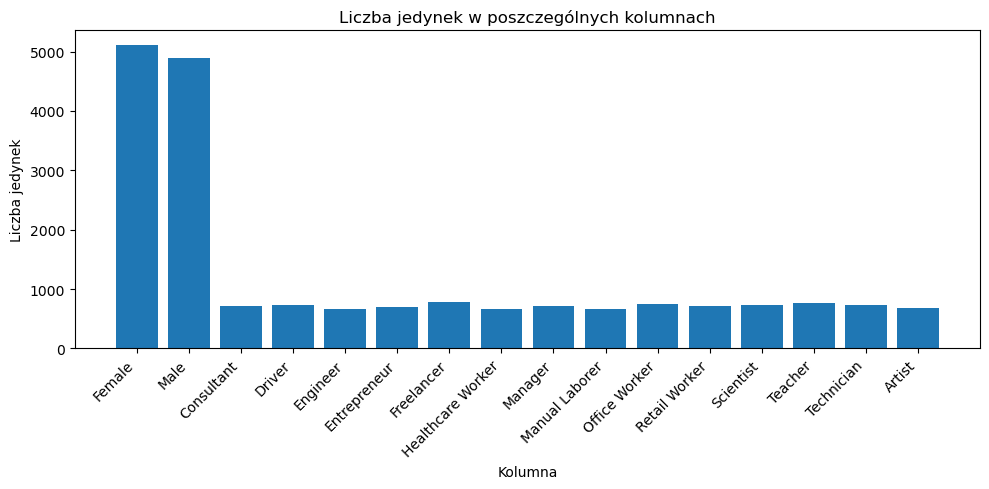

In [4]:
# Wykres kolumnowy

ones_per_column = data[data.columns[:-5]].sum()
ones_per_column['Female'] = data.shape[0] - ones_per_column['Male']
ones_per_column['Artist'] = data.shape[0] - sum(ones_per_column[1:-1])

ones_per_column = ones_per_column[['Female', *ones_per_column.index[:-2], 'Artist']]

plt.figure(figsize=(10, 5))
plt.bar(ones_per_column.index, ones_per_column.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Liczba jedynek")
plt.xlabel("Kolumna")
plt.title("Liczba jedynek w poszczególnych kolumnach")
plt.tight_layout()
plt.show()

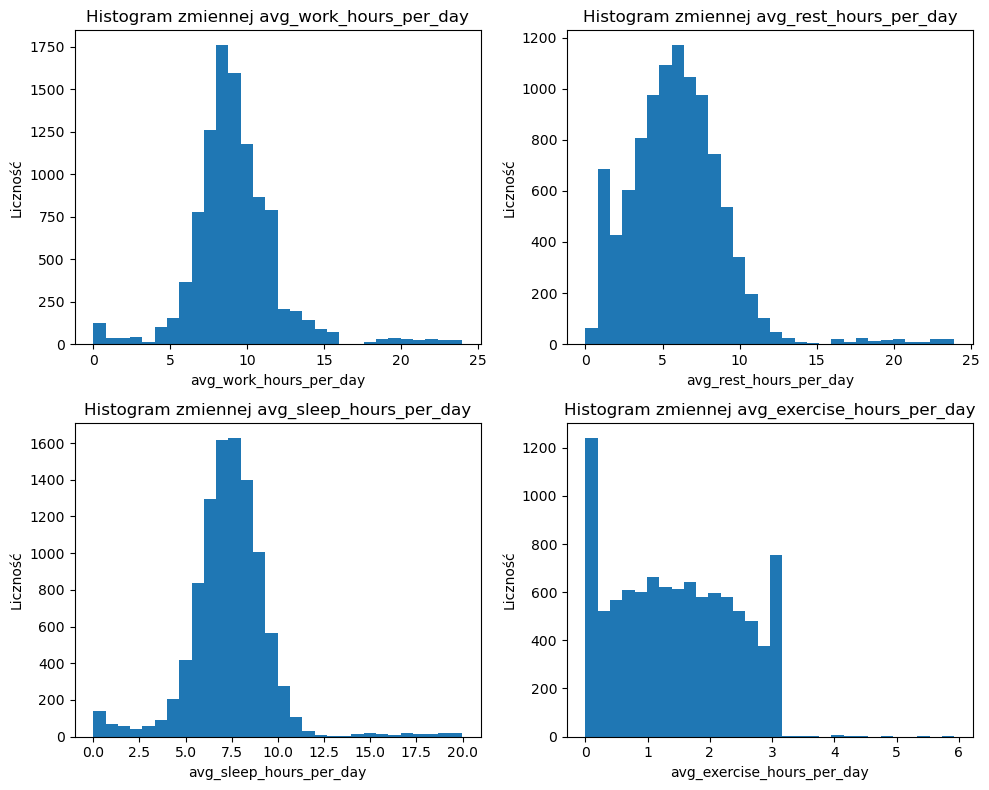

In [5]:
# Histogram

cols = ["avg_work_hours_per_day", "avg_rest_hours_per_day", "avg_sleep_hours_per_day", "avg_exercise_hours_per_day"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.hist(data[col], bins=30)
    ax.set_title(f"Histogram zmiennej {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Liczność")

plt.tight_layout()
plt.show()

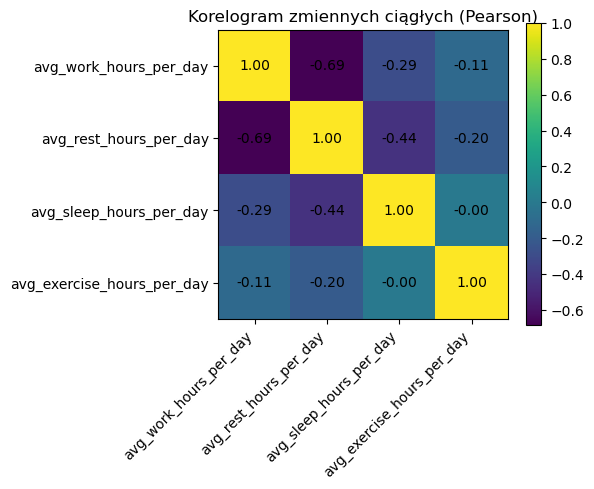

In [6]:
# Korelogram
corr_matrix = data[cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(6, 5))

cax = ax.imshow(corr_matrix.values)

ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))

ax.set_xticklabels(cols)
ax.set_yticklabels(cols)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# wartości liczbowe na wykresie
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha="center", va="center")

fig.colorbar(cax)
ax.set_title("Korelogram zmiennych ciągłych (Pearson)")
plt.tight_layout()
plt.show()

Wykres kolumnowy:

Wykres kolumnowy umożliwia ocenę rozkładu wartości pomiędzy zmiennymi dyskretnymi. W przypadku zmiennej opisującej płeć respondentów można zaobserwować nieznaczną przewagę udziału kobiet w badaniu ankietowym. Wykres przedstawia również strukturę próby ze względu na wykonywaną profesję. Na podstawie samej wizualizacji trudno jednoznacznie wskazać zawód wyraźnie dominujący nad pozostałymi. Udział poszczególnych profesji wśród respondentów wydaje się relatywnie równomierny.


Wykres histogramow:

Zaprezentowane histogramy ilustrują rozkłady czterech zmiennych ciągłych. W przypadku zmiennych opisujących średni dzienny czas pracy oraz średni dzienny czas snu widoczna jest silna koncentracja obserwacji wokół wartości średnich. Rozkłady te charakteryzują się podwyższoną kurtozą i można je określić jako leptokurtyczne, przypominające kształtem rozkłady o cięższych ogonach, zbliżone do rozkładu t-Studenta. Zmienna dotycząca średniego dziennego czasu odpoczynku również wykazuje większą kurtozę niż rozkład normalny, jednak efekt ten jest mniej wyraźny niż w przypadku wcześniej omawianych zmiennych. Odmienną charakterystykę prezentuje zmienna opisująca średni dzienny czas ćwiczeń. Pomijając skrajne wartości, jej rozkład mógłby sugerować charakter platykurtyczny, jednak silna koncentracja obserwacji w okolicach zera oraz wartości trzech godzin wskazuje na rozkład niestandardowy, odbiegający od klasycznych założeń normalności.


Korelogram:

Korelogram ukazuje istotne zależności pomiędzy zmiennymi ciągłymi. Ze względu na ograniczoną liczbę godzin w ciągu doby, występowanie ujemnych korelacji pomiędzy poszczególnymi aktywnościami jest zjawiskiem intuicyjnie oczekiwanym. Najsilniejsza ujemna korelacja obserwowana jest pomiędzy średnim dziennym czasem pracy a średnim dziennym czasem odpoczynku. Można to tłumaczyć faktem, że osoby niepracujące dysponują większą ilością wolnego czasu, który w większym stopniu przeznaczają na odpoczynek. Ujemne zależności występują również pomiędzy średnim dziennym czasem snu a pozostałymi zmiennymi. Osoby śpiące dłużej przeznaczają mniej czasu na pracę oraz inne aktywności, w tym odpoczynek, przy czym korelacja pomiędzy czasem snu a czasem odpoczynku okazuje się silniejsza niż w przypadku relacji snu z czasem pracy.

## Utils functions

In [7]:
def report(reals, predictors):
    conf_matrix_Smote_test = confusion_matrix(reals, predictors)
    sns.heatmap(conf_matrix_Smote_test, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(classification_report(reals, predictors))

    tn, fp, fn, tp = confusion_matrix(reals, predictors).ravel()
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)
    accuracy = (tn +  tp) / (tn + tp + fp + fn)
    print("Specificity(Specyficzność):", round(specificity, 2))
    print("Recall(Czułość):", round(recall, 2))
    print("Accuracy(Dokładność):", round(accuracy, 2))

def wknn_tuner(train_x, train_y, test_x, test_y):
    n_neighbors = [2,3,5,8]
    results = []

    for n in n_neighbors:
        wknn = KNeighborsClassifier(n_neighbors=n, weights='distance')
        wknn.fit(train_x, train_y)

        y_pred_train_wknn= wknn.predict(train_x)
        y_pred_test_wknn = wknn.predict(test_x)


        cm_train=confusion_matrix(train_y, y_pred_train_wknn)
        tn_t, fp_t, fn_t, tp_t = cm_train.ravel()


        specificity_t = tn_t / (tn_t + fp_t) 
        recall_t = tp_t / (tp_t + fn_t) 
        accuracy_t = (tn_t + tp_t) / (tn_t + tp_t + fp_t + fn_t)

        total_score_t = specificity_t + recall_t + accuracy_t

        cm_test = confusion_matrix(test_y, y_pred_test_wknn)
        tn, fp, fn, tp = cm_test.ravel()


        specificity = tn / (tn + fp) 
        recall = tp / (tp + fn) 
        accuracy = (tn + tp) / (tn + tp + fp + fn)

        total_score = specificity + recall + accuracy


        results.append({
            'n': n,
            'model': wknn,
            'cm_train': cm_train,
            'y_train': y_pred_train_wknn,
            'spec train': specificity_t,
            'recall train': recall_t,
            'acc train': accuracy_t,
            'score train': total_score_t,
            'report_train': classification_report(train_y, y_pred_train_wknn),
            'cm_test': cm_test,
            'y_test': y_pred_test_wknn,
            'spec test': specificity,
            'recall test': recall,
            'acc test': accuracy,
            'score test': total_score,
            'report_test': classification_report(test_y, y_pred_test_wknn)
        })

    best_score = max(r['score test'] for r in results)

    winners = [r for r in results if r['score test'] == best_score]


    if len(winners) > 1:
        winner_params = [str(w['n']) for w in winners]
        print(f"Dla wartości parametrów n_neighbors: {', '.join(winner_params)} model jest tak samo dobry")
        print(f"Wynik łączny: {best_score:.4f}\n")
        
        best_model_data = winners[0]
    else:

        best_model_data = winners[0]
        print(f"Najlepszy model uzyskano dla n = {best_model_data['n']}")

    return best_model_data


## Resampling metodą SMOTE

Smote jest synetyczny sposob radzenia sobie z nierownowagą wśród zmiennych. Jest metoda naleząca do oversamplingu, która w przeciwieństwie do Ros, nie duplikuje istniejacych obserwacji ale tworzy nowe. Algortym wybiera otoczenie k najblizszych sasiadow obserwacj nalezącej do klasy mniejszosciowej, a nastepnie poprzez interpolacjie linionwą tworzy nową obserwacje opartą na wartościach przypisanych do losowo wybranego sąsiada. Zaletą tego rozwiazania jest to ze nie duplikujemy bezpośrednio obserwacji więc zmniejszamy ryzko potencjalengo overfittingu, natomiast do wady nalezy zaliczyć fakt iz nowopowstałe obserwacje są sztuczne a więc model moze zachowywac się gorzej przy zastosowaniu do danych realnych.

In [8]:
X=data.drop(columns="Long_life")
y=data["Long_life"]

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)

y_smote.value_counts()

Long_life
0    6325
1    6325
Name: count, dtype: int64

## Skutecznosc SMOTE na przykladowych modelach

### Lasy Losowe

In [9]:
X_Smote_train, X_Smote_test, y_Smote_train, y_Smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=10)

param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [1,3,5,10,15,20]
}

model_RF=RandomForestClassifier()
grid_search = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5)
grid_search.fit(X_Smote_train, y_Smote_train)
print("optymalne parametry")
print(grid_search.best_params_)

model_RF=RandomForestClassifier(n_estimators=grid_search.best_params_["n_estimators"],max_depth=grid_search.best_params_["max_depth"],random_state=42)
model_RF.fit(X_Smote_train,y_Smote_train)

y_pred_train_Smote = model_RF.predict(X_Smote_train)
y_pred_test_Smote = model_RF.predict(X_Smote_test)



optymalne parametry
{'max_depth': 10, 'n_estimators': 150}


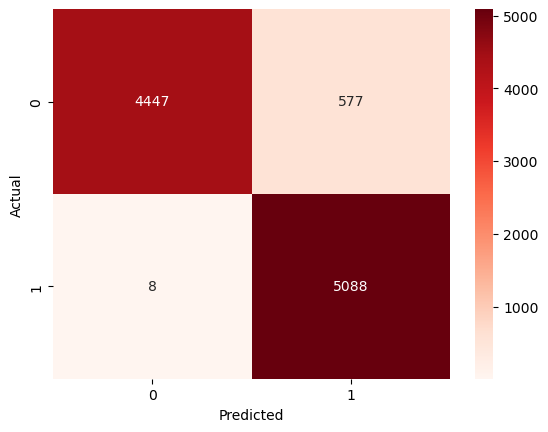

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      5024
           1       0.90      1.00      0.95      5096

    accuracy                           0.94     10120
   macro avg       0.95      0.94      0.94     10120
weighted avg       0.95      0.94      0.94     10120

Specificity(Specyficzność): 0.89
Recall(Czułość): 1.0
Accuracy(Dokładność): 0.94


In [10]:
#zbiór uczący
report(y_Smote_train, y_pred_train_Smote)

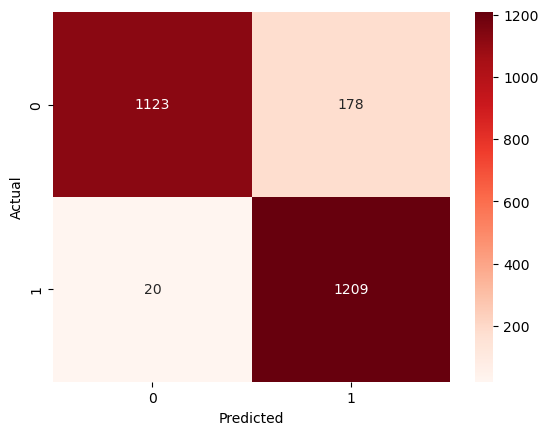

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1301
           1       0.87      0.98      0.92      1229

    accuracy                           0.92      2530
   macro avg       0.93      0.92      0.92      2530
weighted avg       0.93      0.92      0.92      2530

Specificity(Specyficzność): 0.86
Recall(Czułość): 0.98
Accuracy(Dokładność): 0.92


In [11]:
#Zbiór testowy:
report(y_Smote_test, y_pred_test_Smote)

## Wnioski

Model klasyfikacji zbudowany w oparciu o Las Losowy został zoptymalizowany przy użyciu techniki SMOTE, która skutecznie zbalansowała zbiór danych przed procesem uczenia. Dzięki zastosowaniu procedury GridSearchCV z 5-krotną walidacją krzyżową, wyłoniono optymalne parametry modelu, ustalając liczbę drzew na 100 oraz ich maksymalną głębokość na 15 poziomów. Tak skonfigurowany klasyfikator osiągnął bardzo wysokie wyniki: na zbiorze uczącym dokładność wyniosła 96% przy pełnej, 100-procentowej czułości, natomiast na zbiorze testowym parametry te utrzymały się na poziomie odpowiednio 92% i 98%. Niewielka różnica w wydajności między zbiorami oraz wysoka specyficzność świadczą o stabilności modelu i jego dobrej zdolności do generalizacji oraz identyfikowania klasy pozytywnej bez wyraźnych oznak przeuczenia.

### Wazone KNN

In [12]:
best_model_data = wknn_tuner(X_Smote_train, y_Smote_train, X_Smote_test, y_Smote_test)

Najlepszy model uzyskano dla n = 8


zbiór trenujacy
Specificity (Specyficzność): 1.00
Recall (Czułość): 1.00
Accuracy (Dokładność): 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5024
           1       1.00      1.00      1.00      5096

    accuracy                           1.00     10120
   macro avg       1.00      1.00      1.00     10120
weighted avg       1.00      1.00      1.00     10120



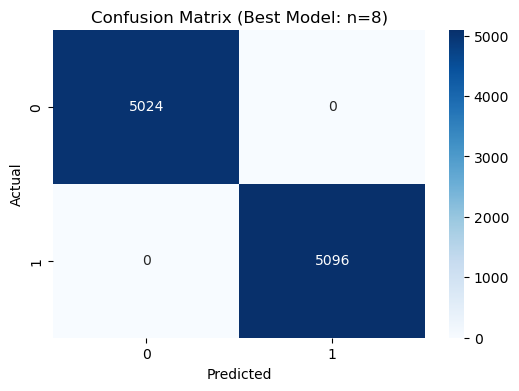

In [13]:
print("zbiór trenujacy")
print(f"Specificity (Specyficzność): {best_model_data['spec train']:.2f}")
print(f"Recall (Czułość): {best_model_data['recall train']:.2f}")
print(f"Accuracy (Dokładność): {best_model_data['acc train']:.2f}")
print(best_model_data['report_train'])

plt.figure(figsize=(6, 4))
sns.heatmap(best_model_data['cm_train'], annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: n={best_model_data["n"]})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Zbiór testujacy
Specificity (Specyficzność): 0.86
Recall (Czułość): 0.97
Accuracy (Dokładność): 0.91
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1301
           1       0.87      0.97      0.92      1229

    accuracy                           0.91      2530
   macro avg       0.92      0.92      0.91      2530
weighted avg       0.92      0.91      0.91      2530



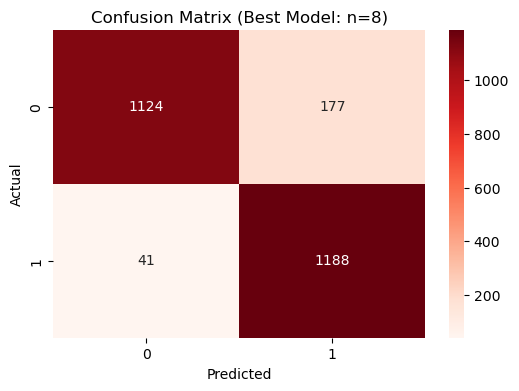

In [14]:
print("Zbiór testujacy")
print(f"Specificity (Specyficzność): {best_model_data['spec test']:.2f}")
print(f"Recall (Czułość): {best_model_data['recall test']:.2f}")
print(f"Accuracy (Dokładność): {best_model_data['acc test']:.2f}")
print(best_model_data['report_test'])


plt.figure(figsize=(6, 4))
sns.heatmap(best_model_data['cm_test'], annot=True, fmt='d', cmap='Reds')
plt.title(f'Confusion Matrix (Best Model: n={best_model_data["n"]})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Wnioski 

Klasyfikacja przy użyciu ważonego modelu k-najbliższych sąsiadów (wKNN) została przeprowadzona na zbiorze zbalansowanym techniką SMOTE, co zapewniło równomierną reprezentację klas. Dzięki autorskiej funkcji tunującej, która testowała różne liczby sąsiadów, za optymalną wartość uznano n = 8. Wykorzystanie wag opartych na odwrotności dystansu, przełożyło się na 100% dopasowanie do zbioru uczącego , co jest naturalną cechą tego algorytmu w fazie treningu. Kluczowe wyniki na zbiorze testowym potwierdziły jednak realną wysoką skuteczność modelu: osiągnięto 91% dokładności oraz bardzo wysoką czułość (97%), co w połączeniu ze specyficznością na poziomie 86% świadczy o dobrej zdolności algorytmu do poprawnego rozpoznawania klasy mniejszościowej przy zachowaniu niskiego poziomu błędów dla klasy większościowej. W porównaniu do modelu Lasu Losowego, ważony KNN uzyskał zbliżoną czułość (97% vs 98%), jednak cechował się nieco niższą dokładnością ogólną (91% vs 92%) oraz niższą specyficznością, co czyni go modelem minimalnie mniej stabilnym, ale wciąż bardzo skutecznym w wykrywaniu przypadków pozytywnych.

## Resampling metodą SMOTE-TOMEK (Hybrid Method)

Metoda SMOTE-Tomek to hybrydowa technika resamplingu, która łączy w sobie zalety nadpróbkowania (oversampling) oraz podpróbkowania (undersampling). Proces rozpoczyna się od zastosowania algorytmu SMOTE, który zwiększa liczebność klasy mniejszościowej poprzez generowanie syntetycznych przykładów. W kolejnym kroku identyfikowane są tzw. Tomek Links, czyli pary obserwacji z przeciwnych klas będące swoimi najbliższymi sąsiadami. Ponieważ takie pary często znajdują się w obszarach nakładania się klas, co może prowadzić do dezorientacji modelu, są one usuwane ze zbioru danych. Dzięki takiemu dwuetapowemu działaniu końcowy zbiór jest nie tylko zbalansowany pod względem liczebności, ale również czystszy pod kątem struktury, co poprawia separację między klasami i ułatwia proces uczenia.

In [15]:
smt = SMOTETomek(sampling_strategy='auto',random_state=42)
X_smt, y_smt = smt.fit_resample(X,y)
y_smt.value_counts()


Long_life
0    6086
1    6086
Name: count, dtype: int64

### Lasy Losowe

In [16]:
X_smt_train, X_smt_test, y_smt_train, y_smt_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=10)

param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [1,3,5,10,15,20]
}

model_RF_smt=RandomForestClassifier()
grid_search_smt = GridSearchCV(estimator=model_RF_smt, param_grid=param_grid, cv=5)
grid_search_smt.fit(X_smt_train, y_smt_train)
print("optymalne parametry")
print(grid_search_smt.best_params_)

model_RF_smt=RandomForestClassifier(n_estimators=grid_search_smt.best_params_["n_estimators"],max_depth=grid_search_smt.best_params_["max_depth"],random_state=42)
model_RF_smt.fit(X_smt_train,y_smt_train)

y_pred_train_smt = model_RF_smt.predict(X_smt_train)
y_pred_test_smt = model_RF_smt.predict(X_smt_test)

optymalne parametry
{'max_depth': 15, 'n_estimators': 150}


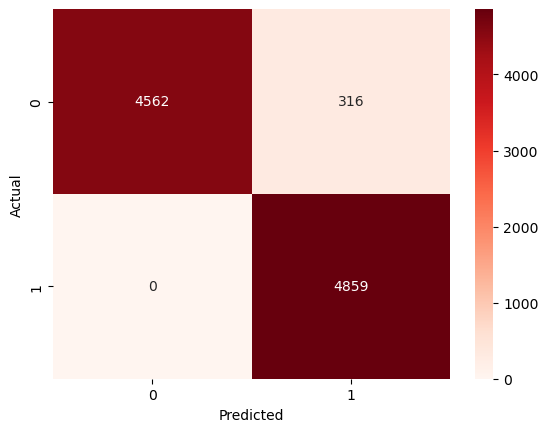

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4878
           1       0.94      1.00      0.97      4859

    accuracy                           0.97      9737
   macro avg       0.97      0.97      0.97      9737
weighted avg       0.97      0.97      0.97      9737

Specificity(Specyficzność): 0.94
Recall(Czułość): 1.0
Accuracy(Dokładność): 0.97


In [17]:
# Zbiór uczący:
report(y_smt_train, y_pred_train_smt)

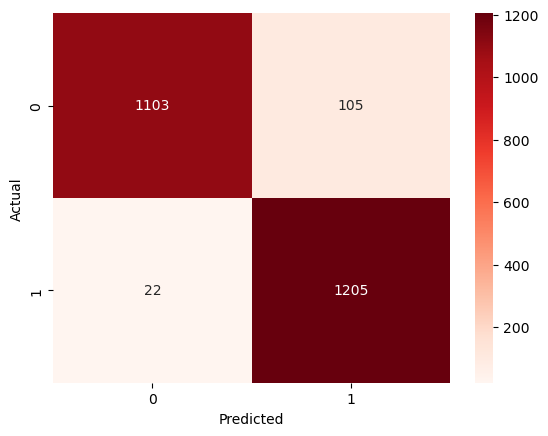

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1208
           1       0.92      0.98      0.95      1227

    accuracy                           0.95      2435
   macro avg       0.95      0.95      0.95      2435
weighted avg       0.95      0.95      0.95      2435

Specificity(Specyficzność): 0.91
Recall(Czułość): 0.98
Accuracy(Dokładność): 0.95


In [18]:
# Zbiór testowy:
report(y_smt_test, y_pred_test_smt)

## Wnioski

Zastosowanie hybrydowej techniki resamplingu SMOTE-Tomek pozwoliło na znaczące podniesienie jakości modelu Lasu Losowego poprzez nie tylko zbalansowanie liczebności klas, ale i precyzyjne wyczyszczenie granicy decyzyjnej z tzw. ogniw Tomka.

W wyniku optymalizacji GridSearchCV wyłoniono konfigurację 150 drzew o głębokości 15, która na zbiorze testowym osiągnęła bardzo wysoką dokładność na poziomie 95% oraz niemal doskonałą czułość wynoszącą 98%. W porównaniu do wcześniej stosowanej klasycznej metody SMOTE, podejście hybrydowe SMOTE-Tomek pozwoliło na wyraźną poprawę specyficzności (wzrost z 87% do 91%), co oznacza skuteczną redukcję błędów typu False Positive przy zachowaniu topowej zdolności do wykrywania klasy pozytywnej. Tak wysoka spójność wyników między zbiorem uczącym a testowym (spadek dokładności o zaledwie 2 p.p.) świadczy o doskonałych właściwościach generalizujących modelu i jego wysokiej odporności na szum, co czyni go najbardziej stabilnym z dotychczas testowanych rozwiązań.

### Wazony KNN

In [19]:
best_model_data = wknn_tuner(X_smt_train, y_smt_train, X_smt_test, y_smt_test)

Najlepszy model uzyskano dla n = 3


zbiór trenujacy
Specificity (Specyficzność): 1.00
Recall (Czułość): 1.00
Accuracy (Dokładność): 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4878
           1       1.00      1.00      1.00      4859

    accuracy                           1.00      9737
   macro avg       1.00      1.00      1.00      9737
weighted avg       1.00      1.00      1.00      9737



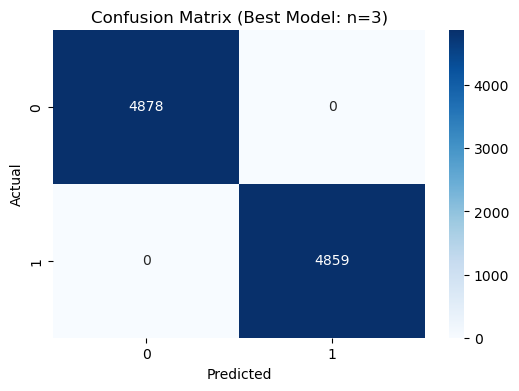

In [20]:
print("zbiór trenujacy")
print(f"Specificity (Specyficzność): {best_model_data['spec train']:.2f}")
print(f"Recall (Czułość): {best_model_data['recall train']:.2f}")
print(f"Accuracy (Dokładność): {best_model_data['acc train']:.2f}")
print(best_model_data['report_train'])

plt.figure(figsize=(6, 4))
sns.heatmap(best_model_data['cm_train'], annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: n={best_model_data["n"]})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Zbiór testujacy
Specificity (Specyficzność): 0.91
Recall (Czułość): 0.97
Accuracy (Dokładność): 0.94
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1208
           1       0.92      0.97      0.94      1227

    accuracy                           0.94      2435
   macro avg       0.94      0.94      0.94      2435
weighted avg       0.94      0.94      0.94      2435



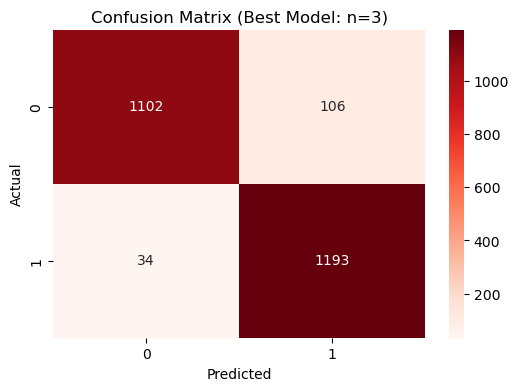

In [21]:
print("Zbiór testujacy")
print(f"Specificity (Specyficzność): {best_model_data['spec test']:.2f}")
print(f"Recall (Czułość): {best_model_data['recall test']:.2f}")
print(f"Accuracy (Dokładność): {best_model_data['acc test']:.2f}")
print(best_model_data['report_test'])


plt.figure(figsize=(6, 4))
sns.heatmap(best_model_data['cm_test'], annot=True, fmt='d', cmap='Reds')
plt.title(f'Confusion Matrix (Best Model: n={best_model_data["n"]})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Wnioski

Wykorzystanie hybrydowej techniki SMOTE-Tomek w połączeniu z ważonym modelem k-najbliższych sąsiadów (wKNN) pozwoliło na uzyskanie wysoce precyzyjnej klasyfikacji dzięki skutecznemu zbalansowaniu klas i wyeliminowaniu szumu na ich granicy. Optymalizacja parametrów wskazała na model z trzema sąsiadami (n=3), który dzięki zastosowaniu wag dystansowych osiągnął idealne wyniki na zbiorze treningowym.

Prawdziwą skuteczność algorytmu potwierdził zbiór testowy, na którym model uzyskał 94% dokładności, imponującą czułość (97%) oraz wysoką specyficzność (91%). W zestawieniu z modelem Lasu Losowego wykorzystującym ten sam resampling SMOTE-Tomek, ważony KNN wykazał się identyczną zdolnością do poprawnego klasyfikowania klasy większościowej (specyficzność 91%) oraz zaledwie minimalnie niższą czułością i dokładnością ogólną, co pozycjonuje go jako bardzo silną i stabilną alternatywę dla modeli opartych na drzewach losowych.

## Skutecznosc przykladowych modeli na danych bez resamplingu

### Lasy Losowe

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [1,3,5,10,15,20]
}

model_RF_noRE=RandomForestClassifier()
grid_search_smt = GridSearchCV(estimator=model_RF_noRE, param_grid=param_grid, cv=5)
grid_search_smt.fit(X_train, y_train)
print("optymalne parametry")
print(grid_search_smt.best_params_)

model_RF_noRE=RandomForestClassifier(n_estimators=grid_search_smt.best_params_["n_estimators"],max_depth=grid_search_smt.best_params_["max_depth"],random_state=42)
model_RF_noRE.fit(X_train,y_train)

y_pred_train = model_RF_noRE.predict(X_train)
y_pred_test = model_RF_noRE.predict(X_test)

optymalne parametry
{'max_depth': 5, 'n_estimators': 200}


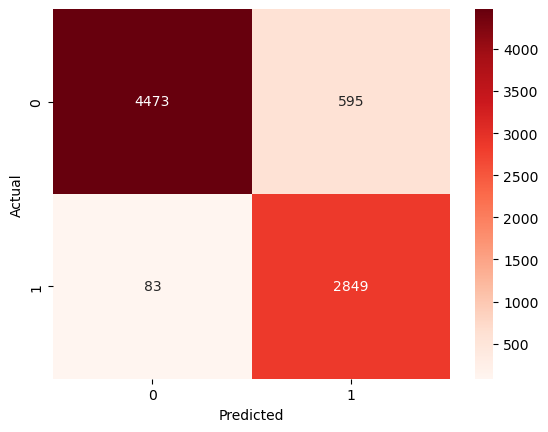

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5068
           1       0.83      0.97      0.89      2932

    accuracy                           0.92      8000
   macro avg       0.90      0.93      0.91      8000
weighted avg       0.93      0.92      0.92      8000

Specificity(Specyficzność): 0.88
Recall(Czułość): 0.97
Accuracy(Dokładność): 0.92


In [23]:
# Zbior uczacy
report(y_train, y_pred_train)

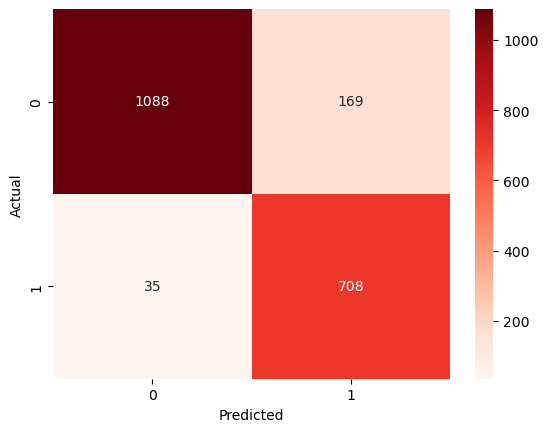

              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1257
           1       0.81      0.95      0.87       743

    accuracy                           0.90      2000
   macro avg       0.89      0.91      0.89      2000
weighted avg       0.91      0.90      0.90      2000

Specificity(Specyficzność): 0.87
Recall(Czułość): 0.95
Accuracy(Dokładność): 0.9


In [24]:
# Zbior testowy
report(y_test, y_pred_test)

### Wazony KNN

In [25]:
best_model_data = wknn_tuner(X_train, y_train, X_test, y_test)

Najlepszy model uzyskano dla n = 8


zbiór trenujacy
Specificity (Specyficzność): 1.00
Recall (Czułość): 1.00
Accuracy (Dokładność): 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5068
           1       1.00      1.00      1.00      2932

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



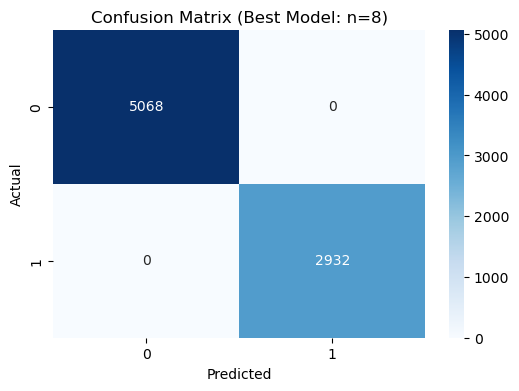

In [26]:
print("zbiór trenujacy")
print(f"Specificity (Specyficzność): {best_model_data['spec train']:.2f}")
print(f"Recall (Czułość): {best_model_data['recall train']:.2f}")
print(f"Accuracy (Dokładność): {best_model_data['acc train']:.2f}")
print(best_model_data['report_train'])

plt.figure(figsize=(6, 4))
sns.heatmap(best_model_data['cm_train'], annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: n={best_model_data["n"]})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Zbiór testujacy
Specificity (Specyficzność): 0.89
Recall (Czułość): 0.87
Accuracy (Dokładność): 0.89
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1257
           1       0.83      0.87      0.85       743

    accuracy                           0.89      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.89      0.89      0.89      2000



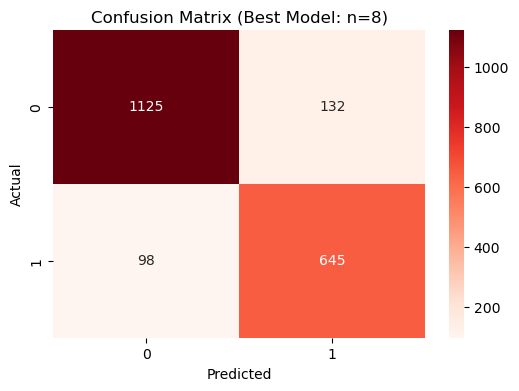

In [27]:
print("Zbiór testujacy")
print(f"Specificity (Specyficzność): {best_model_data['spec test']:.2f}")
print(f"Recall (Czułość): {best_model_data['recall test']:.2f}")
print(f"Accuracy (Dokładność): {best_model_data['acc test']:.2f}")
print(best_model_data['report_test'])


plt.figure(figsize=(6, 4))
sns.heatmap(best_model_data['cm_test'], annot=True, fmt='d', cmap='Reds')
plt.title(f'Confusion Matrix (Best Model: n={best_model_data["n"]})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Wnioski


W analizie modeli Lasu Losowego oraz ważonego KNN przeprowadzonej na oryginalnym, niezbalansowanym zbiorze danych (bez technik resamplingu), oba algorytmy musiały zmierzyć się z naturalną przewagą liczebną klasy większościowej. Optymalizacja Lasu Losowego wyłoniła strukturę 100 drzew o niewielkiej głębokości (max_depth=5), co na zbiorze testowym przełożyło się na 90% dokładności oraz bardzo wysoką czułość (96%). Mimo dobrego wykrywania klasy mniejszościowej, model ten wykazał najniższą specyficzność (86%), co sugeruje, że bez wsparcia metodami SMOTE częściej błędnie przypisuje klasę pozytywną do obserwacji z grupy większościowej.

Z kolei ważony model KNN, mimo idealnego dopasowania do danych uczących, na zbiorze testowym osiągnął ogólną dokładność na poziomie 89%. W porównaniu do Lasu Losowego, KNN wykazał się bardziej stonowaną czułością (87%), ale za to wyższą specyficznością (89%), co oznacza, że lepiej radzi sobie z poprawnym identyfikowaniem klasy większościowej, lecz rzadziej wyłapuje przypadki z grupy mniejszościowej. Brak zastosowania technik resamplingu spowodował, że oba modele osiągnęły wyraźnie słabsze wyniki niż ich odpowiedniki trenowane na danych zbalansowanych, co potwierdza, że dla tego konkretnego problemu wyrównanie liczebności klas jest kluczowe dla uzyskania stabilnego i precyzyjnego klasyfikatora

## Budowanie modeli dla danych SMOTE-Tomek

Na podstawie wcześniejszych rozważań dotyczących struktury próby podjęto decyzję o wykorzystaniu danych poddanych resamplingowi z zastosowaniem algorytmu SMOTE-Tomek. Takie podejście pozwala ograniczyć ryzyko przeszacowania zdolności predykcyjnych modelu względem klasy nadreprezentowanej, a tym samym zmniejsza wpływ niezbalansowania danych na uzyskane wyniki.

W dalszej części analizy zostanie zbudowanych kilka modeli opartych na różnych algorytmach uczenia maszynowego. Następnie, na podstawie porównania ich skuteczności predykcyjnej, wybrany zostanie model najlepiej opisujący badane zjawisko oraz zapewniający najwyższą jakość predykcji.

In [28]:
X_smt_train, X_smt_test, y_smt_train, y_smt_test = train_test_split(X_smt, y_smt, test_size=0.3, random_state=10) # zmiana podzialu test:train na okolo 3:7

scaler = StandardScaler()

X_smt_train_scaled = scaler.fit_transform(X_smt_train)
X_smt_test_scaled = scaler.transform(X_smt_test)

# Regresja logistyczna

In [29]:
lr_pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ('clf', LogisticRegression(max_iter=500))
    ]
)

# rozne solvery obsluguja rozne regularyzacje l1 i l2, dlatego lista slownikow
param_grid = [
    {
        "clf__solver": ["liblinear"],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [0.01, 0.1, 1, 10]
    },
    {
        "clf__solver": ["lbfgs"],
        "clf__penalty": ["l2"],
        "clf__C": [0.01, 0.1, 1, 10]
    }
]

grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_smt_train, y_smt_train)
print("Najlepsze hiperparametry:")
print(grid_search.best_params_)


print("\nNajlepszy wynik:")
print(grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Najlepsze hiperparametry:
{'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}

Najlepszy wynik:
0.9609471469560317


## Prezentacja najlepszego modelu dla regresji logistycznej

In [30]:
lr_model = Pipeline(
    steps=
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                C=1,
                penalty="l1",
                solver="liblinear",
                max_iter=1000,
                random_state=42
            )
        )
    ]
)

lr_model.fit(X_smt_train, y_smt_train)

lr_coef = lr_model.named_steps["clf"].coef_[0]

In [31]:
print('Cecha: Wartosc wspolczynnika')
for coef_, colname in zip(lr_coef, X_smt_train.columns):
    print(f'{colname:<30}: {coef_:>10.4f}')

Cecha: Wartosc wspolczynnika
Male                          :     5.4992
Consultant                    :    -0.1168
Driver                        :    -0.1790
Engineer                      :    -0.1556
Entrepreneur                  :    -0.2723
Freelancer                    :    -0.0852
Healthcare Worker             :    -0.1695
Manager                       :    -0.2151
Manual Laborer                :    -0.1145
Office Worker                 :    -0.0367
Retail Worker                 :    -0.0415
Scientist                     :    -0.0827
Teacher                       :    -0.0377
Technician                    :    -0.1682
avg_work_hours_per_day        :    -0.2510
avg_rest_hours_per_day        :     0.5177
avg_sleep_hours_per_day       :    -0.1598
avg_exercise_hours_per_day    :     0.7098


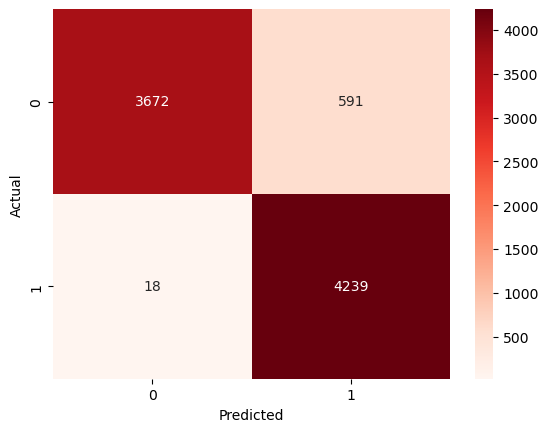

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      4263
           1       0.88      1.00      0.93      4257

    accuracy                           0.93      8520
   macro avg       0.94      0.93      0.93      8520
weighted avg       0.94      0.93      0.93      8520

Specificity(Specyficzność): 0.86
Recall(Czułość): 1.0
Accuracy(Dokładność): 0.93


In [32]:
# Zbior uczacy:
y_smt_train_pred = lr_model.predict(X_smt_train)
report(y_smt_train, y_smt_train_pred)

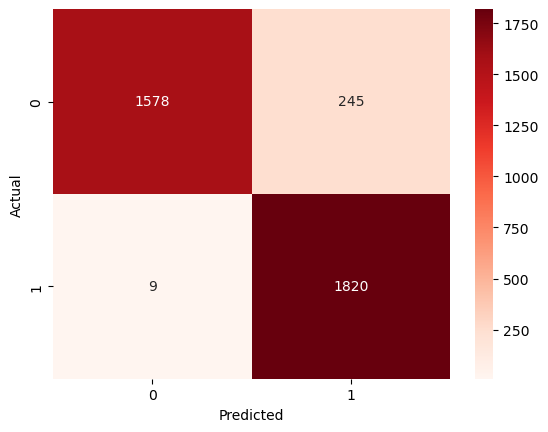

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1823
           1       0.88      1.00      0.93      1829

    accuracy                           0.93      3652
   macro avg       0.94      0.93      0.93      3652
weighted avg       0.94      0.93      0.93      3652

Specificity(Specyficzność): 0.87
Recall(Czułość): 1.0
Accuracy(Dokładność): 0.93


In [33]:
# Zbiór testowy:
y_smt_test_pred = lr_model.predict(X_smt_test)
report(y_smt_test, y_smt_test_pred)

## Wnioski

Regresja logistyczna w implementacji biblioteki scikit-learn bardzo dobrze poradziła sobie z wyjaśnianiem badanego zjawiska. Osiągnięta dokładność na poziomie 93% zarówno na zbiorze uczącym, jak i testowym świadczy o wysokiej jakości dopasowania modelu do danych oraz o braku istotnych oznak przeuczenia. Pomimo zastosowania procedury resamplingu nadal obserwowane są jednak błędy w przewidywaniu jednej z klas, co znajduje odzwierciedlenie w niższej wartości współczynnika specyficzności w porównaniu do czułości.

Ze względu na odmienny sposób implementacji regresji logistycznej w bibliotece scikit-learn nie jest możliwe przeprowadzenie klasycznej analizy ekonometrycznej, obejmującej testy istotności parametrów czy formalną redukcję zmiennych, charakterystycznej dla tradycyjnego modelu logitowego. Analiza modelu ogranicza się zatem do wnioskowania o kierunku wpływu poszczególnych zmiennych na prawdopodobieństwo dożycia średniego wieku.

Model wskazuje, że płeć męska istotnie zwiększa szansę dożycia średniego wieku, co pozostaje spójne z założeniami przyjętymi w danych wejściowych. W odniesieniu do zmiennych zawodowych wykonywanie jakiejkolwiek pracy zawodowej wpływa negatywnie na analizowane prawdopodobieństwo. Zawody takie jak właściciel biznesu, menedżer, technik czy kierowca wykazują silniejszy negatywny wpływ w porównaniu do profesji takich jak pracownik biurowy czy freelancer. Może to wynikać zarówno z charakteru tych zawodów, jak i z poziomu stresu związanego z ich wykonywaniem.

Negatywny wpływ na badane zjawisko wykazują również nadmierne obciążenie pracą oraz zbyt długi czas snu. Z kolei korzystny wpływ przypisywany jest regularnej aktywności fizycznej oraz odpowiedniej ilości czasu przeznaczanego na odpoczynek.

## Support Vector Classifier

In [34]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True))
    ]
)

param_grid = [
    # Kernel liniowy
    {
        "clf__kernel": ["linear"],
        "clf__C": [0.01, 0.1, 1, 10]
    },

    # Kernel RBF
    {
        "clf__kernel": ["rbf"],
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", 0.01, 0.1, 1]
    },

    # Kernel wielomianowy
    {
        "clf__kernel": ["poly"],
        "clf__C": [0.1, 1, 10],
        "clf__degree": [2, 3, 4],
        "clf__gamma": ["scale", 0.1]
    }
]

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_smt_train, y_smt_train)
print("Najlepsze hiperparametry:")
print(grid_search.best_params_)


print("\nNajlepszy wynik:")
print(grid_search.best_score_)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
Najlepsze hiperparametry:
{'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

Najlepszy wynik:
0.9693501925913844


## Prezentacja najlepszego modelu dla SVC

In [35]:
svc_model = Pipeline(
    steps=
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(
                kernel='rbf',
                C=1,
                gamma=0.01
            )
        )
    ]
)

svc_model.fit(X_smt_train, y_smt_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1
,kernel,'rbf'
,degree,3
,gamma,0.01


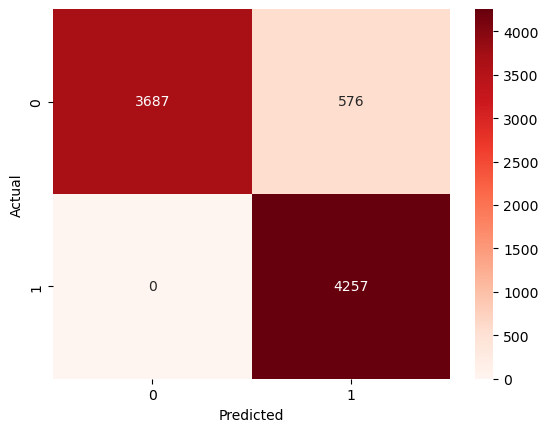

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      4263
           1       0.88      1.00      0.94      4257

    accuracy                           0.93      8520
   macro avg       0.94      0.93      0.93      8520
weighted avg       0.94      0.93      0.93      8520

Specificity(Specyficzność): 0.86
Recall(Czułość): 1.0
Accuracy(Dokładność): 0.93


In [36]:
# Zbior uczacy:
y_smt_train_pred = svc_model.predict(X_smt_train)
report(y_smt_train, y_smt_train_pred)

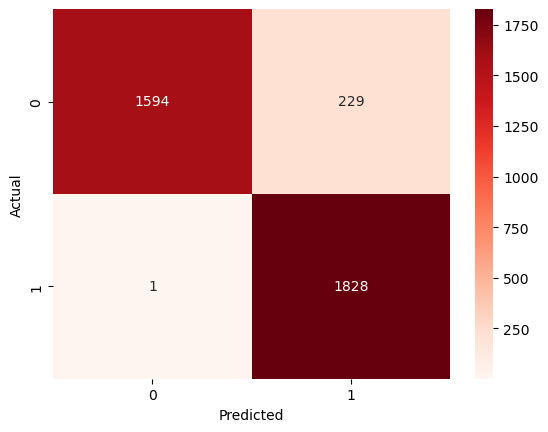

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1823
           1       0.89      1.00      0.94      1829

    accuracy                           0.94      3652
   macro avg       0.94      0.94      0.94      3652
weighted avg       0.94      0.94      0.94      3652

Specificity(Specyficzność): 0.87
Recall(Czułość): 1.0
Accuracy(Dokładność): 0.94


In [37]:
# Zbiór testowy:
y_smt_test_pred = svc_model.predict(X_smt_test)
report(y_smt_test, y_smt_test_pred)

## Wnioski

Model Support Vector Classifier (SVC) z nieliniowym jądrem radialnym (RBF), wykorzystujący najlepszą konfigurację hiperparametrów {C = 1, gamma = 0.01}, wykazał bardzo wysoką skuteczność w predykcji badanego zjawiska. Uzyskane wyniki na zbiorze uczącym oraz testowym są do siebie bardzo zbliżone, co świadczy o dobrej zdolności generalizacji modelu oraz braku istotnych oznak przeuczenia.

Na zbiorze uczącym model osiągnął dokładność na poziomie 93%, natomiast na zbiorze testowym dokładność wzrosła do 94%. W obu przypadkach czułość (recall) dla klasy pozytywnej wyniosła 1.00, co oznacza, że model poprawnie identyfikuje wszystkie obserwacje należące do tej klasy. Jednocześnie wartość specyficzności utrzymuje się na poziomie około 0.86–0.87, co wskazuje na występowanie pewnej liczby błędnych klasyfikacji w klasie negatywnej, choć skala tego zjawiska pozostaje umiarkowana.

Miary precyzji oraz współczynniki F1-score dla obu klas są wysokie i zrównoważone, co potwierdza, że model nie faworyzuje jednej klasy kosztem drugiej. Szczególnie istotny jest fakt, że wyniki makro- i ważonych średnich są niemal identyczne, co sugeruje poprawne radzenie sobie modelu z potencjalnym niezbalansowaniem danych, nawet po zastosowaniu procedury resamplingu.

Ze względu na nieliniowy charakter jądra RBF model SVC nie dostarcza bezpośrednio interpretowalnych współczynników, analogicznych do parametrów regresji logistycznej. Oznacza to, że nie jest możliwe klasyczne wnioskowanie o istotności poszczególnych zmiennych ani jednoznaczna interpretacja kierunku ich wpływu na zmienną objaśnianą. Analiza modelu koncentruje się zatem przede wszystkim na jakości predykcji oraz zdolności rozróżniania klas, a nie na interpretacji strukturalnej zależności pomiędzy zmiennymi.

Podsumowując, model SVC z jądrem RBF okazał się bardzo skutecznym narzędziem predykcyjnym, osiągającym nieco lepsze wyniki niż regresja logistyczna pod względem dokładności na zbiorze testowym. Jednocześnie odbywa się to kosztem utraty interpretowalności charakterystycznej dla modeli parametrycznych, co stanowi typowy kompromis pomiędzy jakością predykcji a możliwością analizy przyczynowej.

## Lasy Losowe

In [38]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_smt_train, y_smt_train)

best_rf = grid_search.best_estimator_

print("Najlepsze hiperparametry:")
print(grid_search.best_params_)

print("Najlepszy wynik:")
print(grid_search.best_score_)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Najlepsze hiperparametry:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Najlepszy wynik:
0.9702277189818315


## Prezentacja najlepszego modelu dla Lasow Losowych

In [39]:
importances = best_rf.feature_importances_

fi = pd.DataFrame(
    {
        "feature": X_smt_train.columns,
        "importance": importances
    }
).sort_values("importance", ascending=False)

print(fi.head(10))

                       feature  importance
0                         Male    0.762873
14      avg_work_hours_per_day    0.082149
16     avg_sleep_hours_per_day    0.056494
15      avg_rest_hours_per_day    0.053471
17  avg_exercise_hours_per_day    0.028066
4                 Entrepreneur    0.007697
7                      Manager    0.003127
6            Healthcare Worker    0.001314
12                     Teacher    0.000998
2                       Driver    0.000907


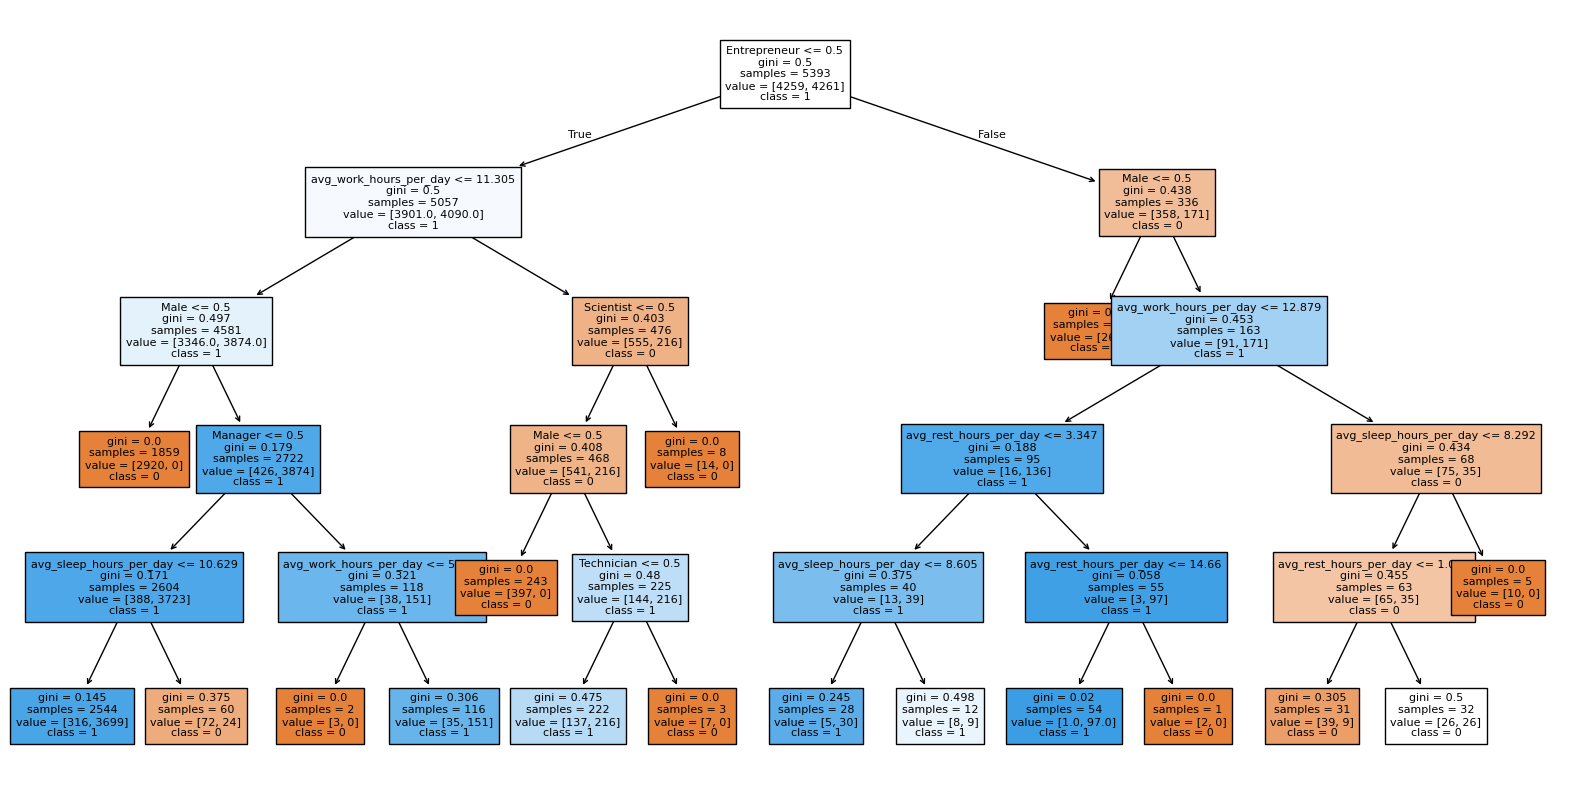

In [40]:
# Wykres najlepszego drzewa z lasow losowych
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf[0],
    feature_names=X_smt_train.columns,
    class_names=["0", "1"],
    filled=True,
    max_depth=10,
    fontsize=8
)
plt.show()

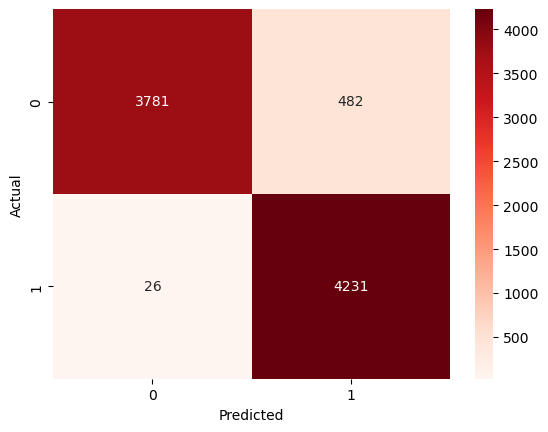

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      4263
           1       0.90      0.99      0.94      4257

    accuracy                           0.94      8520
   macro avg       0.95      0.94      0.94      8520
weighted avg       0.95      0.94      0.94      8520

Specificity(Specyficzność): 0.89
Recall(Czułość): 0.99
Accuracy(Dokładność): 0.94


In [41]:
# Zbior uczacy:
y_smt_train_pred = best_rf.predict(X_smt_train)
report(y_smt_train, y_smt_train_pred)

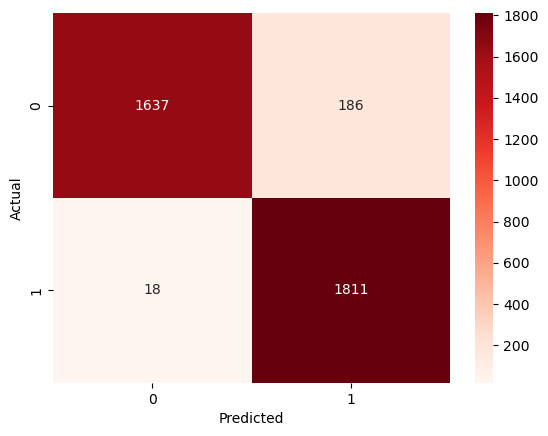

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1823
           1       0.91      0.99      0.95      1829

    accuracy                           0.94      3652
   macro avg       0.95      0.94      0.94      3652
weighted avg       0.95      0.94      0.94      3652

Specificity(Specyficzność): 0.9
Recall(Czułość): 0.99
Accuracy(Dokładność): 0.94


In [42]:
# Zbiór testowy:
y_smt_test_pred = best_rf.predict(X_smt_test)
report(y_smt_test, y_smt_test_pred)

## Wnioski

Model Random Forest skonstruowany przy użyciu konfiguracji hiperparametrów {n_estimators = 300, max_depth = 5, max_features = sqrt, min_samples_split = 2, min_samples_leaf = 1} osiągnął wysoką i stabilną skuteczność predykcyjną zarówno na zbiorze uczącym, jak i testowym. W przeciwieństwie do wcześniejszych eksperymentów z nieograniczoną głębokością drzew, w tym przypadku zastosowano bardziej konserwatywne podejście do kontroli złożoności modelu, co miało na celu ograniczenie tendencji do przeuczenia.

Na zbiorze uczącym model uzyskał dokładność na poziomie 94%, przy bardzo wysokiej czułości wynoszącej 0.99 oraz specyficzności równej 0.89. Wyniki te wskazują na dobrą zdolność modelu do identyfikowania obserwacji należących do klasy pozytywnej, przy jednoczesnym zachowaniu rozsądnego poziomu błędów w klasyfikacji klasy negatywnej. Na zbiorze testowym osiągnięto niemal identyczną dokładność, również na poziomie 94%, a wartości czułości i specyficzności utrzymały się odpowiednio na poziomach 0.99 oraz 0.90. Bardzo zbliżone wyniki dla obu zbiorów potwierdzają dobrą zdolność generalizacji modelu po wprowadzeniu ograniczenia głębokości drzew.

Analiza ważności cech wskazuje, że zmienna opisująca płeć dominuje w procesie decyzyjnym modelu, odpowiadając za ponad 76% całkowitej ważności. Kolejną grupę istotnych predyktorów stanowią zmienne ilościowe związane ze stylem życia, w szczególności średni dzienny czas pracy, snu, odpoczynku oraz aktywności fizycznej. Zmienne zawodowe charakteryzują się zdecydowanie mniejszym wpływem na predykcję, choć zawody takie jak przedsiębiorca czy menedżer nadal wykazują niezerową, choć marginalną, istotność w modelu.

Warto podkreślić, że w początkowych konfiguracjach model lasów losowych wykazywał silną tendencję do przeuczenia, co objawiało się niemal perfekcyjnymi wynikami na zbiorze uczącym przy jednoczesnym pogorszeniu jakości predykcji na zbiorze testowym. Z tego względu konieczne było wymuszenie bardziej racjonalnego podejścia do doboru hiperparametrów, w szczególności poprzez ograniczenie maksymalnej głębokości drzew. Zabieg ten pozwolił znacząco poprawić równowagę pomiędzy dopasowaniem a zdolnością generalizacji modelu.

Podsumowując, zastosowanie kontrolowanej głębokości drzew w modelu Random Forest umożliwiło uzyskanie stabilnych i wiarygodnych wyników predykcyjnych przy jednoczesnym ograniczeniu ryzyka nadmiernego dopasowania. Model ten stanowi kompromis pomiędzy wysoką skutecznością klasyfikacyjną a kontrolą złożoności, oferując dodatkowo możliwość analizy względnej ważności zmiennych, choć kosztem pełnej interpretowalności charakterystycznej dla modeli parametrycznych.

# Podsumowanie

Celem przeprowadzonej analizy było zbadanie czynników wpływających na prawdopodobieństwo dożycia średniego oczekiwanego wieku życia oraz budowa modelu predykcyjnego umożliwiającego skuteczną klasyfikację respondentów do odpowiednich grup. Analiza została przeprowadzona w oparciu o zbiór Life Quality, który po odpowiednich transformacjach zawierał zarówno zmienne binarne opisujące wybrane profesje, jak i zmienne ciągłe związane ze stylem życia, takie jak średni dzienny czas pracy, snu, odpoczynku oraz aktywności fizycznej. Zmienną docelową stanowiła binarna zmienna Long_life, określająca możliwość osiągnięcia średniego oczekiwanego wieku życia, zdefiniowanego osobno dla kobiet i mężczyzn na podstawie danych dla Stanów Zjednoczonych.

Na etapie eksploracji danych zidentyfikowano istotne różnice w rozkładach zmiennych oraz występowanie zależności pomiędzy nimi, w tym korelacje wynikające z ograniczonej liczby godzin w ciągu doby. Dodatkowo stwierdzono niezbalansowanie klas zmiennej docelowej, co uzasadniało zastosowanie metod resamplingu. W celu ograniczenia wpływu nadreprezentowanej klasy oraz poprawy jakości predykcji zastosowano algorytm SMOTE-Tomek, łączący oversampling klasy mniejszościowej z jednoczesnym usuwaniem obserwacji granicznych.

W dalszej części analizy zbudowano i porównano kilka modeli klasyfikacyjnych, w tym regresję logistyczną, model SVC z jądrem RBF oraz model lasów losowych. Regresja logistyczna charakteryzowała się dobrą skutecznością predykcyjną i wysoką stabilnością, jednak jej możliwości interpretacyjne były ograniczone przez sposób implementacji w bibliotece scikit-learn. Model SVC osiągnął bardzo dobre wyniki pod względem dokładności i czułości, lecz jego nieliniowy charakter uniemożliwiał bezpośrednią interpretację wpływu poszczególnych zmiennych.

Ostatecznie jako model końcowy wybrano Random Forest trenowany na danych po resamplingu SMOTE-Tomek. Model ten zapewnił bardzo wysoką skuteczność predykcyjną na zbiorze testowym przy jednoczesnym zachowaniu stabilnych wyników względem zbioru uczącego. W toku eksperymentów zaobserwowano tendencję do przeuczenia przy nieograniczonej głębokości drzew, co skłoniło do przyjęcia bardziej racjonalnego podejścia i wprowadzenia ograniczeń na złożoność modelu. Kontrola głębokości drzew pozwoliła osiągnąć kompromis pomiędzy jakością dopasowania a zdolnością generalizacji.

Dodatkowym atutem modelu lasów losowych była możliwość analizy względnej ważności cech. Wyniki wskazały, że kluczową rolę w predykcji badanego zjawiska odgrywa płeć, a także zmienne związane ze stylem życia, w szczególności czas pracy, snu, odpoczynku oraz aktywności fizycznej. Zmienne zawodowe wykazywały mniejszy, choć niezerowy wpływ na decyzje modelu.

Podsumowując, zastosowanie resamplingu SMOTE-Tomek w połączeniu z modelem lasów losowych pozwoliło uzyskać wysoką jakość predykcji przy jednoczesnym ograniczeniu negatywnych skutków niezbalansowania danych. Wybrany model stanowi skuteczne narzędzie predykcyjne, oferujące dobry kompromis pomiędzy trafnością klasyfikacji, odpornością na przeuczenie oraz możliwością analizy istotności zmiennych, co czyni go najbardziej odpowiednim rozwiązaniem w kontekście przeprowadzonej analizy.